# **Final Project: Crypto Wallet Transaction Risk Classification**
## ME 371: Data-Driven Problem Solving
## Fall 2025
**Name**: Myisha Hassan

**Date**: December 19, 2025

**Dataset**: Elliptic Bitcoin Transaction Dataset sourced from Kaggle (https://www.kaggle.com/datasets/ellipticco/elliptic-data-set)

## 1. Introduction and Problem Statement

**Problem Statement**: To develop a multi-class machine learning model that classifies the risk of Bitcoin cryptocurrency transactions into four risk levels: legitimate, low-risk suspicious, high-risk suspicious, or illicit.

**Motivation**: Risk classification in cryptocurrency transactions is important because blockchain networks lack central oversight making them vulnerable to money laundering, fraud, and scams. As crypto adoption increases, financial institutions and exchanges must detect suspicious transactions at scale. Classifying transaction risk helps flag potential illicit activity early and supports compliance with Anti-Money Laundering regulations. Building an reliable multi-class risk classifier can help platforms, regulators, and users identify and respond to suspicious activity more intelligently.

**Dataset Description**: The Elliptic dataset is a graph-based time-series dataset where Bitcoin transactions form nodes in a temporal transaction graph, with each node described by 166 numerical blockchain features. The dataset contains 203,769 transactions, each labeled as licit, illicit, or unknown. The class distribution is highly imbalanced: approximately 2% illicit, 21% licit, and the remaining 77% labeled as unknown.

Some known challenges of this dataset include having extreme class imbalance, high-dimensionality, and the unknown-label samples require interpretation.

**Success Criteria**:
Model performance is evaluated using metrics appropriate for a multi-class, highly imbalanced AML classification problem. In this context, the primary objective is accurate identification of illicit activity while maintaining reasonable overall balance across all risk classes.

The following metrics are prioritized:

1. Recall for Class 3 (Illicit):
Recall on the illicit class is the most important metric, as false negatives correspond to illicit transactions going undetected. In AML applications, failing to identify illicit behavior poses a significantly higher risk than incorrectly flagging legitimate or low-risk transactions.

2. Precision for Class 3 (Illicit):
Precision for the illicit class is also critical in order to limit false alarms. Excessive false positives can overwhelm compliance teams and reduce the practical usefulness of the model in real-world monitoring systems.

3. Macro- and Weighted-Averaged F1-Score:
Macro-averaged F1-score is used to assess balanced performance across all four risk classes, treating each class equally despite severe class imbalance. Weighted F1-score is reported as a complementary metric to reflect overall performance while accounting for class prevalence.

Additional metrics such as overall accuracy and confusion matrices are included to provide context and support qualitative interpretation of model behavior, but accuracy alone is not relied upon as this is an imbalanced dataset.


## 2. Data Loading and Overview

This project uses the Elliptic Bitcoin Transaction Dataset, which consists of
three components: a transaction-level feature matrix, class labels, and an edge
list describing transaction flows as a directed graph. The feature matrix
contains 203,769 Bitcoin transactions, each represented by 166 numerical
blockchain features. The class labels categorize transactions as licit,
illicit, or unknown, and the edge list encodes connectivity between
transactions in the network.

In this section, I load and merge the three data sources, inspect the dataset
shape and feature types, check for missing values, examine the class
distribution (to identify potential imbalance issues), and compute basic
descriptive statistics for the numerical features.

In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling / evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.base import clone

# Imbalance handling
from imblearn.over_sampling import SMOTE

# XGBoost
from xgboost import XGBClassifier

# Graph utilities
from collections import defaultdict

In [ ]:
# Load datasets
feat_path = "/content/drive/MyDrive/ME371_Data_Driven/elliptic_txs_features.csv"
class_path = "/content/drive/MyDrive/ME371_Data_Driven/elliptic_txs_classes.csv"
edge_path  = "/content/drive/MyDrive/ME371_Data_Driven/elliptic_txs_edgelist.csv"

# Features file has no header row (per dataset format)
df_feat = pd.read_csv(feat_path, header=None)
df_class = pd.read_csv(class_path)
df_edges = pd.read_csv(edge_path)

# Rename transaction ID columns in all dataframes
df_feat.rename(columns={0: "tx_id"}, inplace=True)
df_class.rename(columns={"txId": "tx_id"}, inplace=True)
df_edges.rename(columns={"txId1": "tx_id1", "txId2": "tx_id2"}, inplace=True)

# Merge features + class labels
df = df_feat.merge(df_class, on="tx_id", how="left")

# Display datasets
print('\nMerged dataset (first 5 rows):')
display(df.head())
print('\nEdge list (first 5 rows):')
display(df_edges.head())

# Dataset structure
print("Feature matrix shape:", df_feat.shape)
print("Class label shape:", df_class.shape)
print("Edge list shape:", df_edges.shape)
print("Merged dataset shape:", df.shape)

# Feature types
print("\nFeature types:")
display(df.dtypes.value_counts())

# Missing values overview
total_missing = df.isnull().sum().sum()
print(f"\nTotal missing values in dataset: {total_missing}")

# Descriptive statistics
desc_stats = df.drop(columns=["tx_id", "class"]).describe().T
display(desc_stats.head())


Merged dataset (first 5 rows):


,tx_id,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown



Edge list (first 5 rows):


,tx_id1,tx_id2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


Feature matrix shape: (203769, 167)
Class label shape: (203769, 2)
Edge list shape: (234355, 2)
Merged dataset shape: (203769, 168)

Feature types:


,count
float64,165
int64,2
object,1



Total missing values in dataset: 0


,count,mean,std,min,25%,50%,75%,max
1,203769.0,2.384396e+01,15.172170,1.000000,9.000000,23.000000,38.000000,49.000000
2,203769.0,2.454849e-17,1.000002,-0.172983,-0.172532,-0.169204,-0.131855,71.681966
3,203769.0,-7.531922e-18,1.000002,-0.210553,-0.180327,-0.132897,-0.055242,73.595052
4,203769.0,2.231681e-17,1.000002,-1.756361,-1.201369,0.463609,1.018602,2.683580
5,203769.0,6.241732e-17,1.000002,-0.121970,-0.121970,-0.121970,-0.121970,49.027598


## 3.  Exploratory Data Analysis

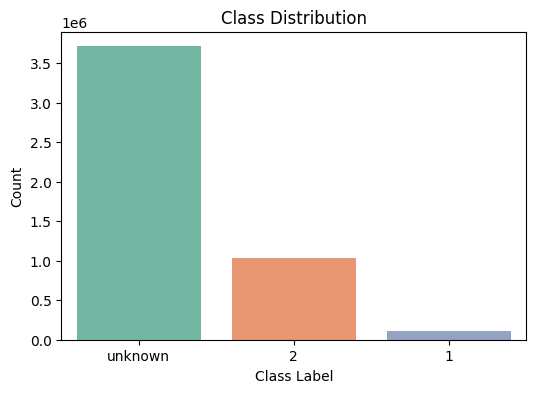


Class proportions:


,proportion
class,
unknown,0.771
2,0.206
1,0.022


In [ ]:
# Plot 1: Class distribution: check for label imbalance
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df, hue="class", palette="Set2", legend=False)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

print("\nClass proportions:")
display(df["class"].value_counts(normalize=True).round(3))

*Figure 1. Class distribution of transaction labels. The dataset is highly
imbalanced: most transactions are labeled as unknown, a smaller portion are
licit, and only a very small fraction are illicit. This imbalance will need to
be addressed during model development to avoid a classifier that ignores the
illicit class.*


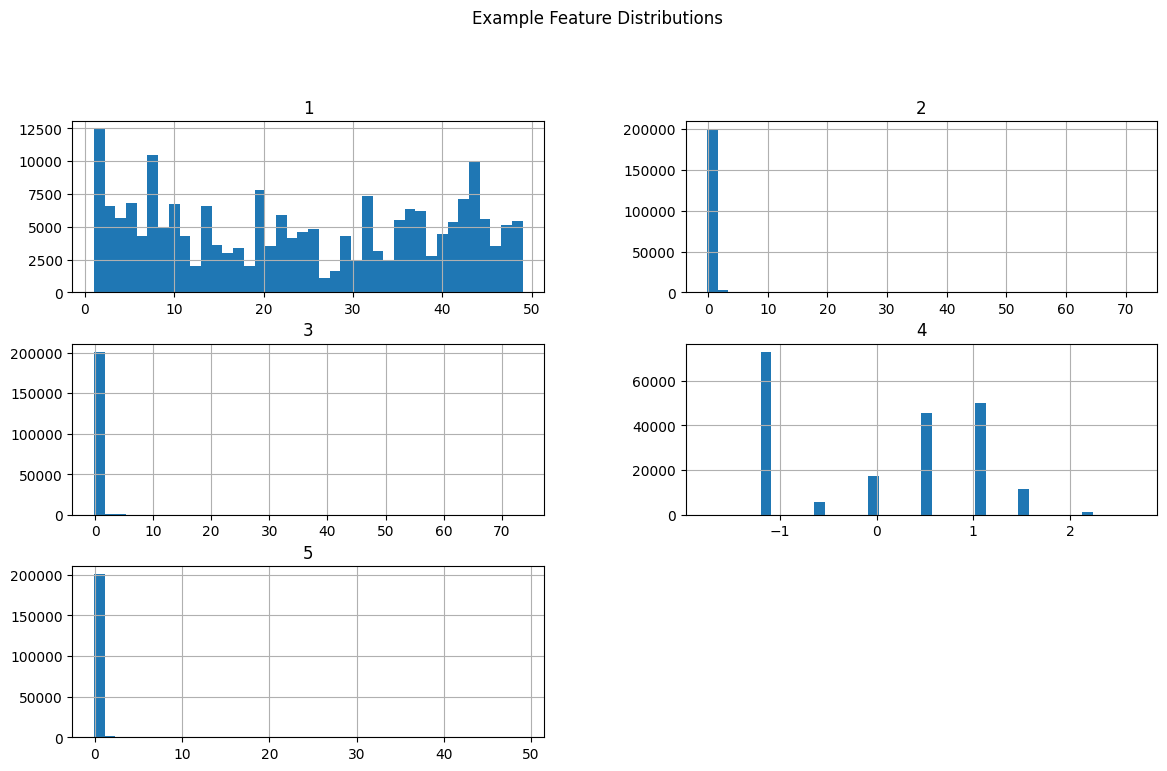

In [ ]:
# Plot 2: Feature distribution examples (first 5 features)
sample_features = df.columns[1:6]

df[sample_features].hist(figsize=(14,8), bins=40)
plt.suptitle("Example Feature Distributions", y=1.02)
plt.show()

*Figure 2. Example feature distributions from the Elliptic transaction dataset. Many features show strong right skew, heavy-tailed behavior, and highly concentrated mass near zero, while others show broader or multi-modal distributions.*

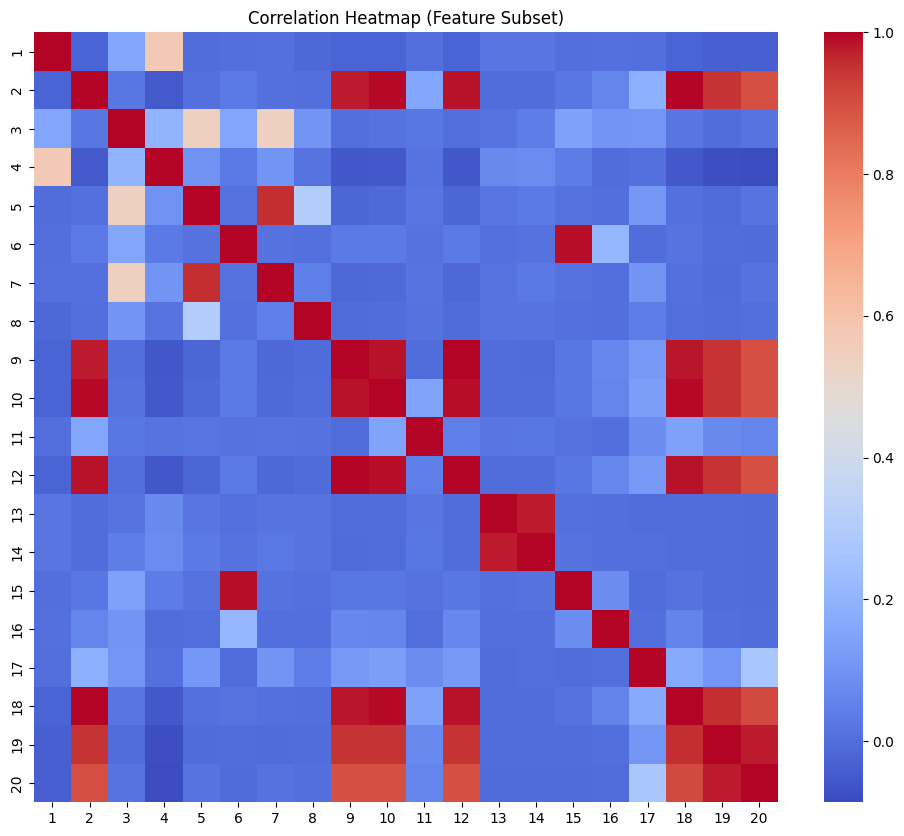

In [ ]:
# Plot 3: Correlation heatmap
corr = df.drop(columns=["tx_id", "class"]).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr.iloc[:20, :20], cmap="coolwarm")
plt.title("Correlation Heatmap (Feature Subset)")
plt.show()

*Figure 3. Correlation heatmap for a subset (first 20x20) of transaction-level features from the Elliptic dataset. Several feature groups show strong positive correlations (indicating redundancy and shared information among related blockchain attributes) while most other feature pairs show weak correlation.*

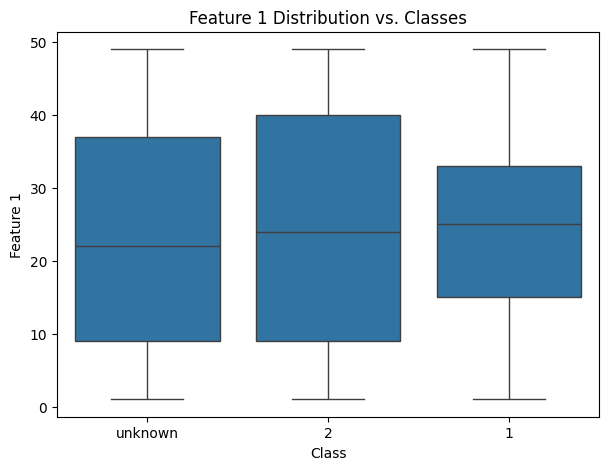

In [ ]:
# Plot 4: boxplot across classes
plt.figure(figsize=(7,5))
sns.boxplot(x="class", y=1, data=df) # feature #1
plt.title("Feature 1 Distribution vs. Classes")
plt.xlabel("Class")
plt.ylabel("Feature 1")
plt.show()

*Figure 4. Boxplot of Feature 1 across transaction classes (unknown, licit, and illicit). Differences in median values and dispersion across classes suggest that this feature contains class-dependent information. This overlap indicates that no single feature is sufficient for reliable classification thus requiring multi-feature models.*

From the boxplots and correlation heatmap, it is evident that individual features show variation across classes and moderate inter feature correlation. Although no single feature cleanly separates licit and illicit transactions, combinations of transaction-level attributes contain meaningful information motivating the use of multivariate + nonlinear classification models for analysis.


Outlier count: 16878


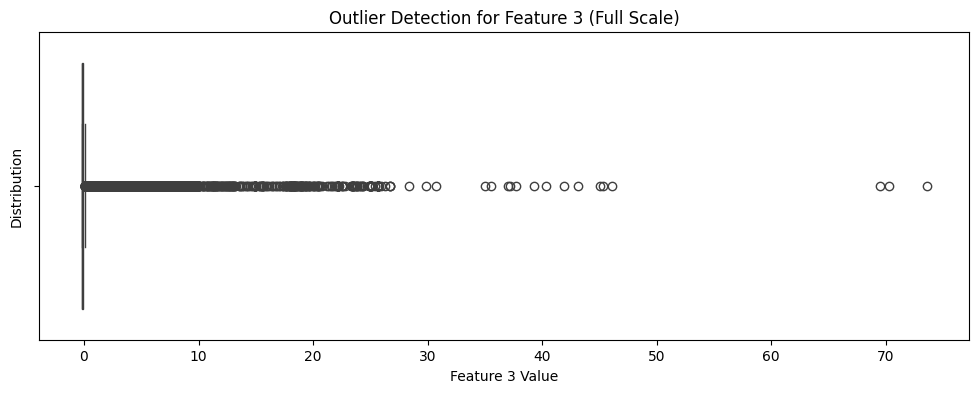

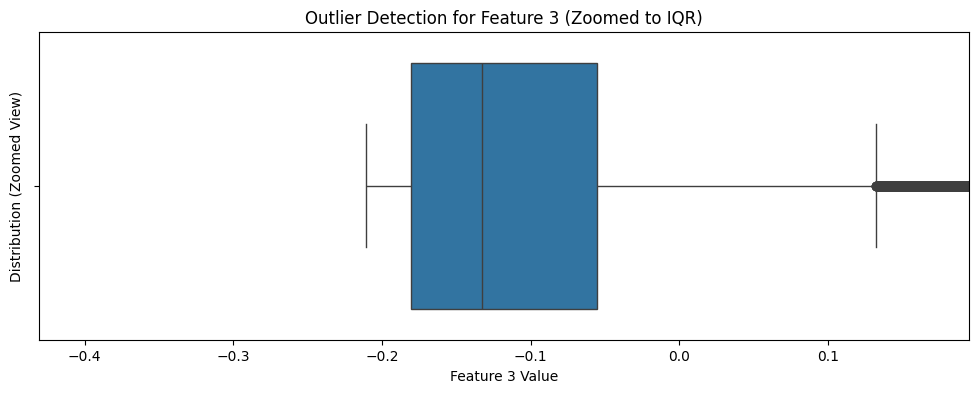

In [ ]:
# Plot 5: Outlier detection (full scale)

feature = 3  # example feature index

q1 = df[feature].quantile(0.25)
q3 = df[feature].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df[(df[feature] < lower) | (df[feature] > upper)]
print("Outlier count:", len(outliers))

plt.figure(figsize=(12,4))
sns.boxplot(x=df[feature])

plt.title("Outlier Detection for Feature 3 (Full Scale)")
plt.xlabel("Feature 3 Value")
plt.ylabel("Distribution")
plt.show()

# Plot 6: Outlier detection (zoomed to IQR region)

plt.figure(figsize=(12,4))
sns.boxplot(x=df[feature], whis=1.5)

# Zoom x-axis to highlight IQR and whiskers
plt.xlim(lower - 0.5 * iqr, upper + 0.5 * iqr)

plt.title("Outlier Detection for Feature 3 (Zoomed to IQR)")
plt.xlabel("Feature 3 Value")
plt.ylabel("Distribution (Zoomed View)")
plt.show()

*Figures 5-6 illustrate outlier detection for Feature 3. The full-scale boxplot reveals heavy-tailed behavior with extreme outliers, while the zoomed view highlights the interquartile range (IQR) criterion. The majority of observations are concentrated near small values, while a large number of extreme outliers extend far beyond the upper quartile. This heavy-tailed behavior is characteristic of blockchain transaction features. Many blockchain features contain extreme outliers due to large transaction values or bursts of activity. Thus, we will need to use robust nonlinear models rather than aggressive outlier removal.*

**EDA Summary**:

Exploratory analysis reveals that the Elliptic dataset is highly imbalanced, high-dimensional, and characterized by skewed feature distributions with significant outliers. Many feature variables have correlation while class-based visualizations indicate  differences between risk groups. These findings motivate the use of feature scaling, imbalance handling, and nonlinear models.

## Multi-Class Transformation
The original dataset provides three labels: licit, illicit, and unknown. While this formulation is useful for binary classification, it does not capture varying degrees of risk among transactions with unknown labels. In real-world AML systems, transactions often exist on a risk spectrum rather than as strictly legal or illegal.

To better reflect this reality, the problem is reformulated as a four-class risk classification task:

- Class 0 Legitimate: Known licit transactions

- Class 1 Low-Risk Unknown: Unknown transactions with limited exposure to illicit activity

- Class 2 High-Risk Unknown: Unknown transactions with strong exposure to illicit activity

- Class 3 Illicit: Known illicit transactions

This transformation allows the model to differentiate between varying degrees of suspicious behavior and produces outputs that are more actionable for AML monitoring.


In [ ]:
# Map original class codes to readable labels
df["class_str"] = df["class"].astype(str)
label_map = {"2": "licit", "1": "illicit", "unknown": "unknown"}
df["label_raw"] = df["class_str"].map(label_map)

# Split BEFORE constructing 4-class risk labels to avoid leakage
df_train, df_temp = train_test_split(
    df,
    test_size=0.30,
    random_state=0,
    stratify=df["label_raw"]
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.50,  # 0.50 of the 0.30 => 0.15 val, 0.15 test
    random_state=0,
    stratify=df_temp["label_raw"]
)

print("Split sizes:")
print("Train:", df_train.shape, " Val:", df_val.shape, " Test:", df_test.shape)

Split sizes:
Train: (142638, 170)  Val: (30565, 170)  Test: (30566, 170)


**Graph-Based Neighbor Count Computation**

The dataset includes a transaction graph in which nodes represent transactions and edges represent relationships between them. This graph structure is leveraged to quantify the risk exposure of unknown transactions.

For each transaction, an illicit neighbor count is computed, defined as the number of directly connected neighboring transactions that are known to be illicit. The transaction graph is treated as undirected, and neighbor relationships are constructed using the provided edge list.

**Risk Class Assignment Logic**

Risk classes are assigned using the following rules:

- Transactions labeled licit are assigned Class 0 (Legitimate).

- Transactions labeled illicit are assigned Class 3 (Illicit).

- Transactions labeled unknown are subdivided based on illicit neighbor exposure:

  - Class 1 (Low-Risk Unknown): Fewer than two illicit neighbors

  - Class 2 (High-Risk Unknown): Two or more illicit neighbors

The High-Risk (Class 2) group is intentionally strict (≥2 illicit neighbors), which yields a very small class. This makes class-2 metrics high-variance, so macro metrics and per-class recall are emphasized over accuracy

**Why Proximity to Illicit Nodes Indicates Higher Risk**

In transaction networks, illicit activity tends to propagate through direct relationships such as shared wallets, repeated interactions, or intermediary transactions. Unknown transactions that are closely connected to known illicit activity are therefore more likely to be suspicious.

Incorporating graph-based proximity allows the model to leverage relational context that is not captured by tabular features alone, aligning the labeling strategy with real-world AML risk assessment practices.

**Data Leakage Prevention and Verification**

Because risk classes (1 and 2) depend on illicit-neighbor counts in the transaction graph, strict measures were taken to prevent data leakage. The dataset was split into training, validation, and test sets before any graph-based label construction. Illicit transactions were identified only from the training set, and validation/test transactions were assigned risk labels based on their connectivity to these historically known illicit nodes. Validation and test labels were never used to identify illicit neighbors or influence risk-class assignment. Finally, graph-derived neighbor counts were used solely for target construction and were excluded from the model feature set, ensuring no label information leaked into training.

In [ ]:
# Use ONLY training set illicit nodes as "historically known illicit activity"
illicit_ids_train = set(df_train.loc[df_train["label_raw"] == "illicit", "tx_id"])

# Assign 4-class risk labels using graph proximity to train-known illicit nodes.
def compute_risk_labels_for_split(split_df, edge_df, illicit_ids_train):
    split_df = split_df.copy()
    split_ids = set(split_df["tx_id"])

    # Keep edges incident to nodes in this split. Cross-split edges are allowed.
    split_edges = edge_df[
        edge_df["tx_id1"].isin(split_ids) |
        edge_df["tx_id2"].isin(split_ids)
    ]

    # Build adjacency list
    neighbor_dict = defaultdict(set)
    for _, edge in split_edges.iterrows():
        a, b = edge["tx_id1"], edge["tx_id2"]
        neighbor_dict[a].add(b)
        neighbor_dict[b].add(a)

    # Count how many neighbors are in the TRAIN illicit reference set
    def count_illicit_neighbors(tx_id):
        neighs = neighbor_dict.get(tx_id, set())
        return sum(n in illicit_ids_train for n in neighs)

    split_df["n_illicit_neighbors"] = split_df["tx_id"].apply(count_illicit_neighbors)

    def assign_risk_class(row):
        # Keep original licit/illicit as endpoints of the risk spectrum
        if row["label_raw"] == "licit":
            return 0
        elif row["label_raw"] == "illicit":
            return 3
        else:
            # Unknowns are subdivided into low vs high risk
            return 2 if row["n_illicit_neighbors"] >= 2 else 1

    split_df["risk_class"] = split_df.apply(assign_risk_class, axis=1)
    return split_df

df_train = compute_risk_labels_for_split(df_train, df_edges, illicit_ids_train)
df_val   = compute_risk_labels_for_split(df_val,   df_edges, illicit_ids_train)
df_test  = compute_risk_labels_for_split(df_test,  df_edges, illicit_ids_train)

# Verify distributions
print("\nRisk class distribution (TRAIN):")
print(df_train["risk_class"].value_counts().sort_index())
print("\nRisk class distribution (VALIDATION):")
print(df_val["risk_class"].value_counts().sort_index())
print("\nRisk class distribution (TEST):")
print(df_test["risk_class"].value_counts().sort_index())


Risk class distribution (TRAIN):
risk_class
0     29413
1    109863
2       180
3      3182
Name: count, dtype: int64

Risk class distribution (VALIDATION):
risk_class
0     6303
1    23535
2       46
3      681
Name: count, dtype: int64

Risk class distribution (TEST):
risk_class
0     6303
1    23547
2       34
3      682
Name: count, dtype: int64


Neighbor counts for validation/test were computed using edges incident to validation/test nodes so that risk could be assessed relative to historically known illicit activity from the training period. Importantly, only training-set illicit labels were used to identify illicit neighbors; validation/test labels were never used in neighbor counting.

**Class Distribution After Transformation**

After applying the four-class transformation, class distributions were examined separately for the training, validation, and test sets. As expected, the dataset remains highly imbalanced, with high-risk and illicit classes representing a small fraction of all samples. This imbalance motivated the later use of resampling techniques and macro-averaged evaluation metrics.

#### Leakage Verification

In [ ]:
# Leakage Verification: Four-class graph-based label creation

# 1) Ensure the splits are disjoint by tx_id (no overlap across partitions)
train_ids = set(df_train["tx_id"])
val_ids   = set(df_val["tx_id"])
test_ids  = set(df_test["tx_id"])

assert train_ids.isdisjoint(val_ids),  "Leakage check failed: train and val share tx_ids."
assert train_ids.isdisjoint(test_ids), "Leakage check failed: train and test share tx_ids."
assert val_ids.isdisjoint(test_ids),   "Leakage check failed: val and test share tx_ids."

# 2) Ensure illicit_ids_train is derived ONLY from df_train labels
illicit_ids_train_check = set(df_train.loc[df_train["label_raw"] == "illicit", "tx_id"])
assert illicit_ids_train == illicit_ids_train_check, (
    "Leakage check failed: illicit_ids_train is not strictly derived from df_train."
)

# 3) Ensure we did NOT use validation/test labels to define illicit reference
assert len(illicit_ids_train & val_ids) == 0,  "Leakage check failed: illicit reference contains val tx_ids."
assert len(illicit_ids_train & test_ids) == 0, "Leakage check failed: illicit reference contains test tx_ids."

# 4) Sanity check: neighbor counts are computed only relative to train illicit IDs
# (i.e., the count function checks membership in illicit_ids_train, not split-local illicit IDs)
assert isinstance(illicit_ids_train, set) and len(illicit_ids_train) > 0, "Sanity check failed: illicit_ids_train empty."

print("Leakage verification passed!")
print("- Train/Val/Test tx_id partitions are disjoint.")
print("- Illicit reference set is derived only from training labels.")
print("- Neighbor counting uses train-only illicit reference (no val/test labels).")
print("- Note: incident edges are allowed by design to assess proximity to historically known illicit nodes.")


Leakage verification passed!
- Train/Val/Test tx_id partitions are disjoint.
- Illicit reference set is derived only from training labels.
- Neighbor counting uses train-only illicit reference (no val/test labels).
- Note: incident edges are allowed by design to assess proximity to historically known illicit nodes.


**Leakage Verification for Four-Class Label Creation (Train-Only Illicit Reference)**

Because Classes 1 and 2 are defined using illicit-neighbor counts from the transaction graph, steps were taken to prevent data leakage. The dataset was split into training, validation, and test sets before any graph-based label construction. The set of illicit nodes used for neighbor counting `illicit_ids_train` was derived only from training labels and treated as historically known illicit activity. Validation and test labels were never used to identify illicit neighbors or influence risk-class assignment.
Neighbor counts were computed using edges incident to nodes in each split so that validation/test transactions could be assessed relative to historically known illicit activity. Finally, the graph-derived neighbor count `n_illicit_neighbors` was used only to create the target `risk_class` and was excluded from the model feature set during training.

## 4. Data Preprocessing

This section prepares the dataset for machine learning by addressing feature scaling, class imbalance using resampling techniques, and data splitting.

#### Scaling and Resampling

To prevent data leakage, scaling parameters must be learned from the training set only:

1. Split into train/test first using stratified sampling.
2. Fit `StandardScaler` on `X_train` only.
3. Transform `X_train` and `X_test` using the same scaler.
4. Apply SMOTE only to the scaled training set.


In [ ]:
# Exclude identifiers, raw labels, and graph derived quantities to prevent leakage
exclude_cols = ["tx_id", "class", "class_str", "label_raw", "risk_class", "n_illicit_neighbors"]

# Use only feature columns present in ALL splits (prevents column mismatch)
feature_columns = sorted(
    (set(df_train.columns) & set(df_val.columns) & set(df_test.columns)) - set(exclude_cols)
)

X_train, y_train = df_train[feature_columns].copy(), df_train["risk_class"].copy()
X_val,   y_val   = df_val[feature_columns].copy(),   df_val["risk_class"].copy()
X_test,  y_test  = df_test[feature_columns].copy(),  df_test["risk_class"].copy()

# Impute missing values using TRAIN statistics only (prevents leakage)
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_columns)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=feature_columns)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=feature_columns)

# Make feature names consistent
X_train.columns = X_train.columns.astype(str)
X_val.columns   = X_val.columns.astype(str)
X_test.columns  = X_test.columns.astype(str)

print("Train/Val/Test shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  " y_test: ", y_test.shape)

Train/Val/Test shapes:
X_train: (142638, 166)  y_train: (142638,)
X_val:   (30565, 166)  y_val:   (30565,)
X_test:  (30566, 166)  y_test:  (30566,)


In [ ]:
# Standardize features: fit scaler on TRAIN only (prevents leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled:  ", X_val_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)

Scaled shapes:
X_train_scaled: (142638, 166)
X_val_scaled:   (30565, 166)
X_test_scaled:  (30566, 166)


In [ ]:
# Apply SMOTE ONLY on training data
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution before SMOTE (train):")
display(y_train.value_counts().sort_index())

print("\nClass distribution after SMOTE (train):")
display(pd.Series(y_train_smote).value_counts().sort_index())


Class distribution before SMOTE (train):


,count
risk_class,
0,29413
1,109863
2,180
3,3182



Class distribution after SMOTE (train):


,count
risk_class,
0,109863
1,109863
2,109863
3,109863


**Data Splitting and Leakage Prevention**

The dataset is split into training (70%), validation (15%), and test (15%) sets using stratified sampling based on the raw class labels to preserve class proportions across all splits. All preprocessing steps are learned exclusively from the training set and then applied to the validation and test sets to prevent data leakage.

**Missing Value Handling and Feature Selection**

Only transaction-level numerical features are used for modeling. Identifiers, labels, and graph-derived quantities (including the illicit neighbor count) are explicitly excluded to avoid leakage. Missing values are imputed using the mean computed from the training set only, and the same imputation parameters are applied to the validation and test sets.

**Feature Scaling**

Feature scaling is performed using standardization (zero mean, unit variance), with scaling parameters fitted on the training set only. Logistic Regression is sensitive to feature scale because it optimizes a linear decision boundary using gradient-based methods; without scaling, features with larger variance can dominate the loss function.

**Handling Class Imbalance with SMOTE**

The dataset has extreme class imbalance, particularly for the high-risk and illicit classes. To address this, SMOTE is applied only to the scaled training data to generate synthetic minority-class examples. Applying SMOTE to validation or test sets would leak information across splits and artificially inflate performance estimates. So, all model evaluation and final reporting are conducted on untouched validation and test data.

## 5. Model Development

The two machine learning models implemented are the Multinomial Logistic Regression and XGBoost. Each model is evaluated in two configurations: a baseline trained on the imbalanced data and a SMOTE-balanced version trained on resampled data.

### Model 1: Multinomial Logistic Regression


=== Logistic Regression Baseline ===
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      6303
           1       0.92      0.70      0.79     23547
           2       0.02      0.85      0.04        34
           3       0.12      0.83      0.21       682

    accuracy                           0.70     30566
   macro avg       0.43      0.77      0.43     30566
weighted avg       0.85      0.70      0.76     30566



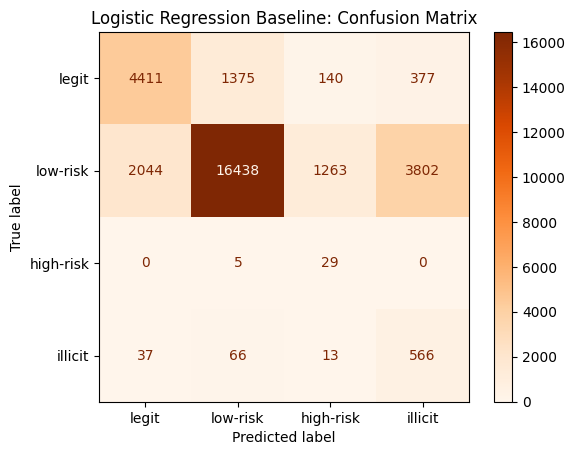

In [ ]:
# Baseline multinomial logistic regression (trained on imbalanced data)
lr_baseline = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)
# Fit on scaled training data
lr_baseline.fit(X_train_scaled, y_train)
# Evaluate on test set
y_pred_lr_base = lr_baseline.predict(X_test_scaled)

print("=== Logistic Regression Baseline ===")
print(classification_report(y_test, y_pred_lr_base, zero_division=0))

# Confusion matrix for baseline
cm_lr_base = confusion_matrix(y_test, y_pred_lr_base, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(
    cm_lr_base,
    display_labels=["legit", "low-risk", "high-risk", "illicit"]
).plot(cmap="Oranges")
plt.title("Logistic Regression Baseline: Confusion Matrix")
plt.show()

Multinomial Logistic Regression is used to directly model the four-class risk structure in a single unified framework. Class weighting is applied in the baseline model to address the extreme class imbalance, particularly for the high-risk and illicit classes. Without class weighting, Logistic Regression collapses to predicting majority classes and yields near-zero recall for minority classes.

SMOTE is evaluated separately below as an alternative imbalance-handling strategy. Keeping class weighting in the baseline while introducing SMOTE as a separate comparison allows for a clear contrast between loss-based reweighting and data-level resampling, which is especially important in AML settings where minority-class detection is critical.

=== Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      6303
           1       0.92      0.73      0.81     23547
           2       0.02      0.82      0.05        34
           3       0.14      0.84      0.24       682

    accuracy                           0.73     30566
   macro avg       0.44      0.77      0.45     30566
weighted avg       0.85      0.73      0.77     30566



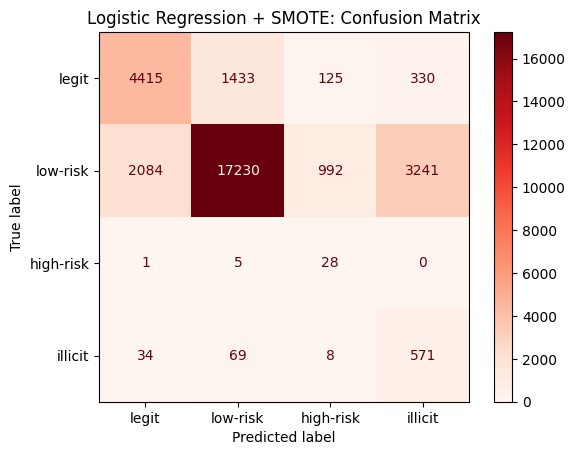

In [ ]:
# Logistic regression (trained on SMOTE-balanced data)
lr_smote = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)

## Train on SMOTE-balanced training data
lr_smote.fit(X_train_smote, y_train_smote)
# Evaluate on test set
y_pred_lr_smote = lr_smote.predict(X_test_scaled)

print("=== Logistic Regression + SMOTE ===")
print(classification_report(y_test, y_pred_lr_smote, zero_division=0))

# Confusion matrix for SMOTE model
cm_lr_smote = confusion_matrix(y_test, y_pred_lr_smote, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(
    cm_lr_smote,
    display_labels=["legit", "low-risk", "high-risk", "illicit"]
).plot(cmap="Reds")
plt.title("Logistic Regression + SMOTE: Confusion Matrix")
plt.show()

### Model 2: XGBoost (Gradient Boosted Trees)


The Elliptic features are high-dimensional and may contain nonlinear interactions. Gradient-boosted trees can capture nonlinear decision boundaries and feature interactions that linear models cannot. This makes XGBoost a strong candidate for distinguishing illicit behavior patterns from legitimate and unknown transaction behavior.

=== XGBoost Baseline ===
              precision    recall  f1-score   support

       legit       0.93      0.87      0.90      6303
    low-risk       0.96      0.98      0.97     23547
   high-risk       0.70      0.21      0.32        34
     illicit       0.87      0.78      0.82       682

    accuracy                           0.95     30566
   macro avg       0.87      0.71      0.75     30566
weighted avg       0.95      0.95      0.95     30566



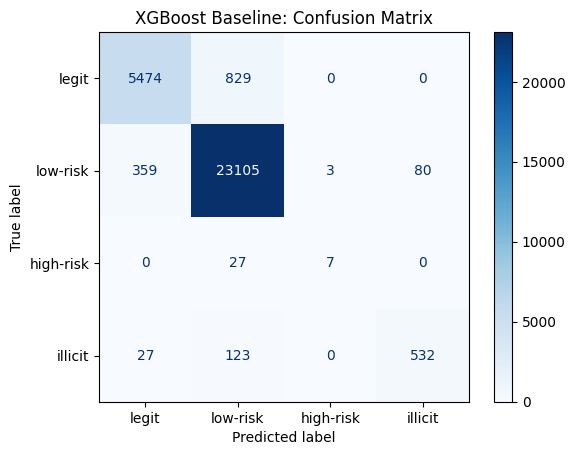

In [ ]:
# Baseline XGBoost (trained on imbalanced data)
xgb_baseline = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

# Fit on training data (scaled for consistency across models)
xgb_baseline.fit(X_train_scaled, y_train)
# Evaluate on test set
y_pred_xgb_base = xgb_baseline.predict(X_test_scaled)

print("=== XGBoost Baseline ===")
print(classification_report(
    y_test,
    y_pred_xgb_base,
    target_names=["legit", "low-risk", "high-risk", "illicit"],
    zero_division=0
))

# Confusion Matrix for baseline model
cm_xgb_base = confusion_matrix(y_test, y_pred_xgb_base, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(
    cm_xgb_base,
    display_labels=["legit", "low-risk", "high-risk", "illicit"]
).plot(cmap="Blues")
plt.title("XGBoost Baseline: Confusion Matrix")
plt.show()

=== XGBoost + SMOTE ===
              precision    recall  f1-score   support

       legit       0.91      0.87      0.89      6303
    low-risk       0.96      0.97      0.97     23547
   high-risk       0.30      0.38      0.34        34
     illicit       0.76      0.83      0.79       682

    accuracy                           0.95     30566
   macro avg       0.73      0.76      0.75     30566
weighted avg       0.95      0.95      0.95     30566



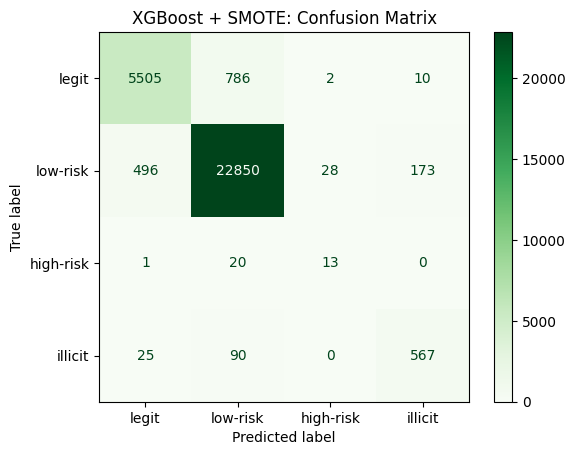

In [ ]:
# XGBoost (trained on SMOTE-balanced data)
xgb_smote = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

# Train on SMOTE-resampled training data only
xgb_smote.fit(X_train_smote, y_train_smote)
# Evaluate on test set
y_pred_xgb_smote = xgb_smote.predict(X_test_scaled)

print("=== XGBoost + SMOTE ===")
print(classification_report(
    y_test,
    y_pred_xgb_smote,
    target_names=["legit", "low-risk", "high-risk", "illicit"],
    zero_division=0
))

# Confusion Matrix for SMOTE model
cm_xgb_smote = confusion_matrix(y_test, y_pred_xgb_smote, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(
    cm_xgb_smote,
    display_labels=["legit", "low-risk", "high-risk", "illicit"]
).plot(cmap="Greens")
plt.title("XGBoost + SMOTE: Confusion Matrix")
plt.show()

### Compare Performance: Baseline vs SMOTE (LogReg + XGBoost)

,Model,Accuracy,F1 (macro),F1 (weighted),High-Risk Recall (Class 2),Illicit Recall (Class 3)
0,LogReg Baseline,0.701564,0.432701,0.758171,0.852941,0.829912
1,LogReg + SMOTE,0.727737,0.446683,0.774998,0.823529,0.837243
2,XGBoost Baseline,0.952627,0.752678,0.951694,0.205882,0.780059
3,XGBoost + SMOTE,0.946640,0.747206,0.946595,0.382353,0.831378


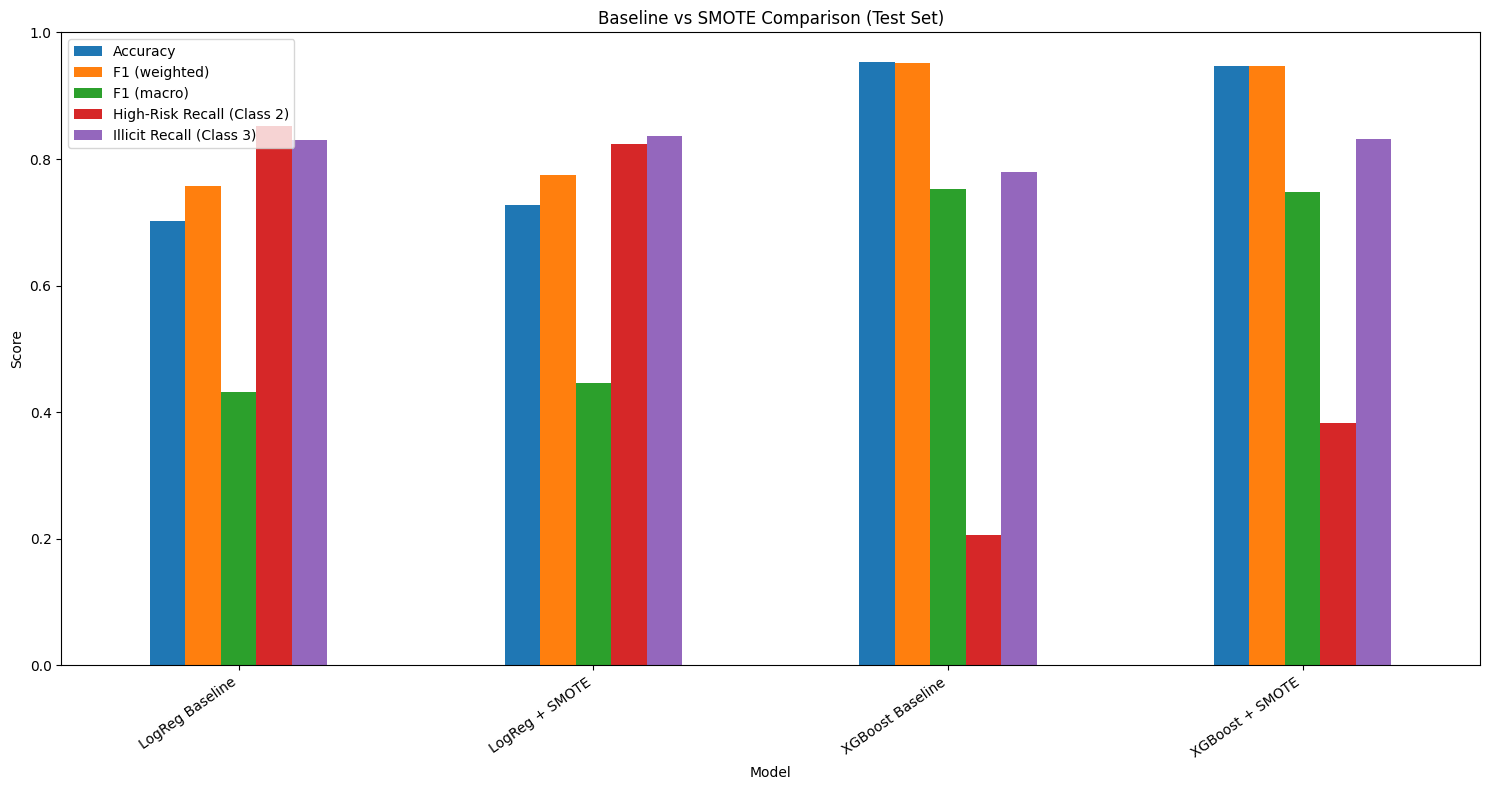

In [ ]:
def compare_baseline_vs_smote(model_name: str, y_true, y_pred_base, y_pred_smote) -> pd.DataFrame:
    """Return a 2-row DataFrame comparing baseline vs SMOTE for one model type."""
    rows = []
    for variant_name, y_pred in [
        (f"{model_name} Baseline", y_pred_base),
        (f"{model_name} + SMOTE", y_pred_smote),
    ]:
        rows.append({
            "Model": variant_name,
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
            "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
            "High-Risk Recall (Class 2)": recall_score(y_true, y_pred, labels=[2], average=None)[0],
            "Illicit Recall (Class 3)": recall_score(y_true, y_pred, labels=[3], average=None)[0],
        })
    return pd.DataFrame(rows)

# Build comparison tables
lr_compare_df = compare_baseline_vs_smote("LogReg", y_test, y_pred_lr_base, y_pred_lr_smote)
xgb_compare_df = compare_baseline_vs_smote("XGBoost", y_test, y_pred_xgb_base, y_pred_xgb_smote)

# Combined table
smote_comparison_df = pd.concat([lr_compare_df, xgb_compare_df], axis=0, ignore_index=True)
display(smote_comparison_df)

# Side-by-side bar chart
plot_cols = ["Accuracy", "F1 (weighted)", "F1 (macro)",
             "High-Risk Recall (Class 2)" ,"Illicit Recall (Class 3)"]
ax = smote_comparison_df.set_index("Model")[plot_cols].plot(kind="bar", figsize=(15, 8))

plt.title("Baseline vs SMOTE Comparison (Test Set)")
plt.ylabel("Score")
plt.xticks(rotation=35, ha="right")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

**Effect of SMOTE on Minority Class Performance**

For Logistic Regression, SMOTE produced only small changes in macro F1 and illicit recall, consistent with the limitations of a linear classifier under heavy overlap between classes. For XGBoost, SMOTE improved minority-class performance more noticeably where recall for the high-risk unknown class (Class 2) and recall for the illicit class (Class 3) both increased, while overall accuracy remained high.

Baseline models achieve high accuracy by prioritizing majority classes but fail to detect high-risk and illicit transactions. Applying SMOTE substantially improves recall for minority risk classes, especially illicit transactions, at the cost of reduced accuracy. XGBoost consistently outperforms Logistic Regression, and the XGBoost + SMOTE model provides the best balance between overall performance and minority-class detection, aligning with AML objectives.

## 6. Model Optimization

This section refines Logistic Regression and XGBoost using cross-validation, feature selection, and hyperparameter tuning. Cross-validation on SMOTE-resampled data is used for relative model comparison, RFE screens features for interpretability and efficiency, and GridSearchCV identifies effective hyperparameters. Final conclusions are based exclusively on performance on the untouched test set.

### Cross-Validation

Cross-validation was performed on the SMOTE-resampled training set to assess stability under a balanced class distribution. Because SMOTE is applied before cross-validation, these cross-validation scores are used for relative model comparison only, while final performance conclusions are based on the untouched test set.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_cv_scores = cross_val_score(
    clone(lr_baseline),
    X_train_smote,
    y_train_smote,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

xgb_cv_scores = cross_val_score(
    clone(xgb_baseline),
    X_train_smote,
    y_train_smote,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

print("LR + SMOTE Cross-validation (macro F1) scores:", np.round(lr_cv_scores, 4))
print(f"Mean CV F1: {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std()*2:.3f})")

print("\nXGB + SMOTE Cross-validation (macro F1) scores:", np.round(xgb_cv_scores, 4))
print(f"Mean CV F1: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std()*2:.3f})")

LR + SMOTE Cross-validation (macro F1) scores: [0.8134 0.8176 0.8158 0.8164 0.8159]
Mean CV F1: 0.816 (+/- 0.003)

XGB + SMOTE Cross-validation (macro F1) scores: [0.9819 0.9823 0.9827 0.9826 0.9814]
Mean CV F1: 0.982 (+/- 0.001)


Because SMOTE was applied before cross-validation (rather than fitted independently within each training fold), these CV scores are optimistic and are not used as unbiased generalization estimates.

### Feature Selection

Recursive Feature Elimination (RFE) was performed using Logistic Regression as the base estimator due to its stability and interpretability in high-dimensional settings. Logistic Regression was used solely to rank and eliminate weak features, not as the final predictive model. The reduced feature subset was then evaluated using both Logistic Regression and XGBoost to assess whether dimensionality reduction preserved or improved performance across different model families. This approach ensures that feature selection is not tied to a single model and allows evaluation of its generalizability.

In [ ]:
# logistic regression for feature selection
rfe_estimator = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=2000,
    random_state=42,
)

rfe = RFE(
    estimator=rfe_estimator,
    n_features_to_select=30,
    step=10
)

rfe.fit(X_train_smote, y_train_smote)

X_train_smote_rfe = rfe.transform(X_train_smote)
X_test_rfe = rfe.transform(X_test_scaled)

selected_features_rfe = np.array(feature_columns)[rfe.support_]
print(f"Selected {len(selected_features_rfe)} features:")
print(selected_features_rfe)

lr_cv_scores_rfe = cross_val_score(
    clone(lr_baseline),
    X_train_smote_rfe,
    y_train_smote,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

xgb_cv_scores_rfe = cross_val_score(
    clone(xgb_baseline),
    X_train_smote_rfe,
    y_train_smote,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

print("LR + SMOTE + RFE CV (macro F1):", np.round(lr_cv_scores_rfe, 4))
print(f"Mean: {lr_cv_scores_rfe.mean():.3f} (+/- {lr_cv_scores_rfe.std()*2:.3f})")

print("\nXGB + SMOTE + RFE CV (macro F1):", np.round(xgb_cv_scores_rfe, 4))
print(f"Mean: {xgb_cv_scores_rfe.mean():.3f} (+/- {xgb_cv_scores_rfe.std()*2:.3f})")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Selected 30 features:
[  1   6   8  10  11  15  16  18  19  20  23  24  26  29  30  32  35  42
  43  55  60  66  77  78  79  80  85  86 101 104]
LR + SMOTE + RFE CV (macro F1): [0.7345 0.7391 0.738  0.7392 0.7382]
Mean: 0.738 (+/- 0.003)

XGB + SMOTE + RFE CV (macro F1): [0.9578 0.9583 0.9575 0.9587 0.9572]
Mean: 0.958 (+/- 0.001)


**Note on convergence warnings in RFE:** Logistic Regression inside RFE produce convergence warnings due to the large SMOTE-resampled training set and correlated features. This does not invalidate feature ranking, but it suggests the coefficients may not be fully stabilized. Since RFE is used only as a feature screening tool (not the final deployed model), and final evaluation is performed using tuned XGBoost on the test set, these warnings do not affect the final conclusions.

In [ ]:
# RFE impact: macro F1 before vs after feature selection (same CV, same data)

rfe_impact_df = pd.DataFrame({
    "Model": ["LogReg", "XGBoost"],
    "Macro F1 (Before RFE)": [
        lr_cv_scores.mean(),
        xgb_cv_scores.mean()
    ],
    "Macro F1 (After RFE)": [
        lr_cv_scores_rfe.mean(),
        xgb_cv_scores_rfe.mean()
    ]
})

rfe_impact_df["Δ Macro F1"] = (
    rfe_impact_df["Macro F1 (After RFE)"] -
    rfe_impact_df["Macro F1 (Before RFE)"]
)

display(rfe_impact_df)


,Model,Macro F1 (Before RFE),Macro F1 (After RFE),Δ Macro F1
0,LogReg,0.815836,0.737803,-0.078033
1,XGBoost,0.982178,0.957921,-0.024256


Although RFE slightly reduced macro F1, the reduced feature set (from 166 to 30 features) was retained for the hyperparameter tuning step to reduce computational cost and provide a smaller, more interpretable feature subset. Final model performance is evaluated on the untouched test set, so the tuning decision is judged based on test-set outcomes and minority-class performance.

### Hyperparameter Tuning

GridSearchCV was used to tune Logistic Regression and XGBoost on the SMOTE-balanced training set after RFE feature selection. The macro F1-score was used as the optimization metric to emphasize balanced performance across all four classes under severe class imbalance. Cross-validation scores are interpreted as relative model comparisons because SMOTE was applied prior to CV. Final model evaluation is evaluated on the untouched test set.

#### Logistic Regression Tuning Model

In [ ]:
param_grid_lr = {"C": [0.01, 0.1, 1, 10]}

grid_search_lr = GridSearchCV(
    LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        penalty="l2",
        max_iter=2000,
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid_lr,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

# Fit on SMOTE + RFE training data (reduced feature set improves tuning speed)
grid_search_lr.fit(X_train_smote_rfe, y_train_smote)

# Best model found by cross-validated macro F1
best_logreg = grid_search_lr.best_estimator_

print("=== Logistic Regression Grid Search ===")
print("Best parameters:", grid_search_lr.best_params_)
print(f"Best CV score: {grid_search_lr.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


=== Logistic Regression Grid Search ===
Best parameters: {'C': 10}
Best CV score: 0.7401


#### XGBoost Tuning Model

In [ ]:
param_grid_xgb = {
    "n_estimators": [150, 250],
    "max_depth": [3, 5],
    "learning_rate": [0.1],
    "subsample": [0.9],
    "colsample_bytree": [0.9]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    ),
    param_grid=param_grid_xgb,
    scoring="f1_macro",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit on SMOTE + RFE training data to reduce imbalance and dimensionality
grid_search_xgb.fit(X_train_smote_rfe, y_train_smote)

# Best tuned model selected by CV macro F1
best_xgb = grid_search_xgb.best_estimator_

print("=== XGBoost Grid Search ===")
print("Best parameters:", grid_search_xgb.best_params_)
print(f"Best CV Macro F1: {grid_search_xgb.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
=== XGBoost Grid Search ===
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.9}
Best CV Macro F1: 0.9410


### Final Test Evaluation on Tuned Models


=== Tuned Logistic Regression ===
              precision    recall  f1-score   support

       legit       0.78      0.52      0.63      6303
    low-risk       0.87      0.83      0.85     23547
   high-risk       0.04      0.82      0.07        34
     illicit       0.15      0.69      0.24       682

    accuracy                           0.76     30566
   macro avg       0.46      0.71      0.45     30566
weighted avg       0.83      0.76      0.79     30566


=== Tuned XGBoost ===
              precision    recall  f1-score   support

       legit       0.82      0.86      0.84      6303
    low-risk       0.96      0.91      0.94     23547
   high-risk       0.06      0.68      0.11        34
     illicit       0.44      0.82      0.57       682

    accuracy                           0.90     30566
   macro avg       0.57      0.82      0.61     30566
weighted avg       0.92      0.90      0.91     30566



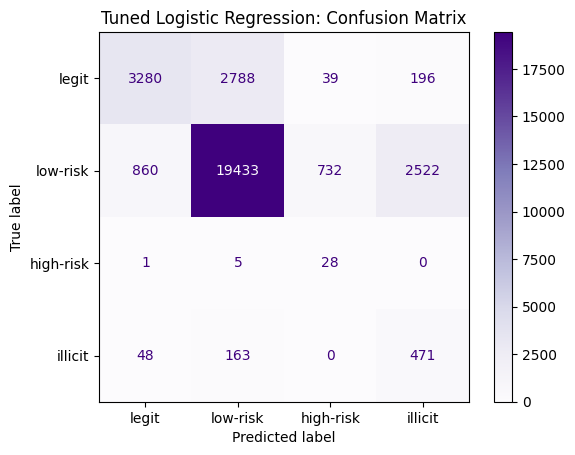

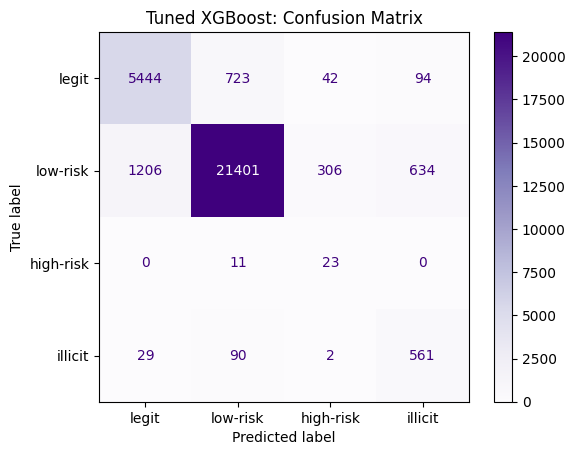

In [ ]:
# Final evaluation of BOTH models on untouched TEST set
y_pred_xgb_tuned = best_xgb.predict(X_test_rfe)
y_pred_lr_tuned = best_logreg.predict(X_test_rfe)

# Metrics
print("\n=== Tuned Logistic Regression ===")
print(classification_report(
    y_test,
    y_pred_lr_tuned,
    target_names=["legit", "low-risk", "high-risk", "illicit"],
    zero_division=0
))

print("\n=== Tuned XGBoost ===")
print(classification_report(
    y_test,
    y_pred_xgb_tuned,
    target_names=["legit", "low-risk", "high-risk", "illicit"],
    zero_division=0
))

# Confusion Matricies
cm_lr_tuned = confusion_matrix(y_test, y_pred_lr_tuned, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(
    cm_lr_tuned,
    display_labels=["legit", "low-risk", "high-risk", "illicit"]
).plot(cmap="Purples")
plt.title("Tuned Logistic Regression: Confusion Matrix")
plt.show()


cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(
    cm_xgb_tuned,
    display_labels=["legit", "low-risk", "high-risk", "illicit"]
).plot(cmap="Purples")
plt.title("Tuned XGBoost: Confusion Matrix")
plt.show()

Confusion matrices for tuned Logistic Regression (left) and tuned XGBoost (right) evaluated on the test set. Logistic Regression achieves high recall for minority classes but severely over-predicts high-risk and illicit transactions, resulting in very low precision and excessive false positives. In contrast, tuned XGBoost maintains strong illicit recall while substantially improving precision and overall stability, correctly classifying most legitimate and low-risk transactions. Misclassifications primarily occur between adjacent risk levels. Class 2 (high-risk unknown) remains difficult for both models due to extremely low support, making metrics for this class inherently unstable.

Thus, while both models can detect illicit activity, the tuned XGBoost model offers the most practical trade-off between catching illicit transactions and minimizing false positives.

### Feature Importance Analysis

Graph structure was used to construct the target labels, but the models were trained only on transaction-level features to avoid leakage. Feature importance indicates the model relies on multiple transaction-derived attributes rather than any single feature

In [ ]:
# feature importance for logistic regression
lr_importance = clone(lr_baseline).fit(X_train_smote, y_train_smote)

# Get coefficients for each class
coef_df = pd.DataFrame(
    lr_importance.coef_,
    columns=feature_columns,
    index=["Class_0", "Class_1", "Class_2", "Class_3"]
)

# Find most important features for illicit class
illicit_coef = coef_df.loc["Class_3"].abs().sort_values(ascending=False)
print("Top 10 features for predicting illicit transactions (LogReg, Class 3):")
display(illicit_coef.head(10))

Top 10 features for predicting illicit transactions (LogReg, Class 3):


,Class_3
15,59.472508
6,58.574410
23,7.937476
29,7.935916
8,7.781064
26,7.020290
32,7.018668
47,6.570434
50,6.036323
11,5.959818


,feature,importance
5,15,0.135222
22,77,0.115524
2,8,0.107544
1,6,0.094212
17,42,0.078652
20,60,0.041305
13,29,0.029641
4,11,0.029214
18,43,0.028446
19,55,0.024425


Top 10 feature importances (XGBoost):


,feature,importance
5,15,0.135222
22,77,0.115524
2,8,0.107544
1,6,0.094212
17,42,0.078652
20,60,0.041305
13,29,0.029641
4,11,0.029214
18,43,0.028446
19,55,0.024425


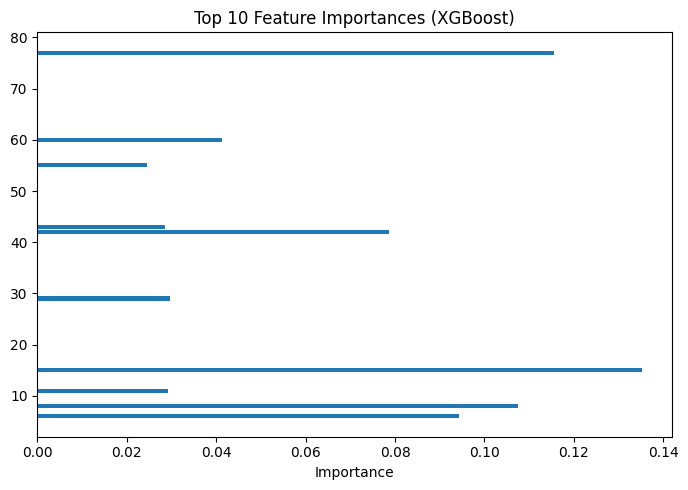

In [ ]:
# feature importance for xgboost
best_xgb.fit(X_train_smote_rfe, y_train_smote)

feat_importance = pd.DataFrame({
    "feature": selected_features_rfe,
    "importance": best_xgb.feature_importances_
}).sort_values("importance", ascending=False)

display(feat_importance.head(10))


print("Top 10 feature importances (XGBoost):")
display(feat_importance.head(10))

# Visualize
plt.figure(figsize=(7, 5))
top_n = 10
plt.barh(
    feat_importance["feature"].head(top_n)[::-1],
    feat_importance["importance"].head(top_n)[::-1]
)
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Top-ranked features in both Logistic Regression coefficients and XGBoost feature importances suggest that illicit identification is influenced by a small subset of transaction attributes. While tree-based feature importance does not prove causality, it indicates that certain transaction-level patterns are repeatedly used by the model to identify risk behaviors.

### Learning Curve

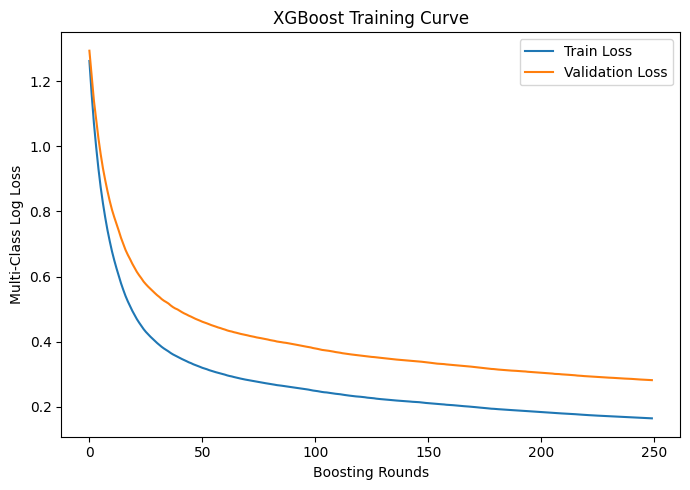

In [ ]:
# XGBoost Training Curve (Loss vs Boosting Rounds)
xgb_curve_model = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    random_state=42,
    **grid_search_xgb.best_params_  # reuse tuned hyperparameters
)

X_val_rfe = rfe.transform(X_val_scaled)

# Train with evaluation set to track loss
xgb_curve_model.fit(
    X_train_smote_rfe,
    y_train_smote,
    eval_set=[(X_train_smote_rfe, y_train_smote),
              (X_val_rfe, y_val)],
    verbose=False
)

# Extract training history
results = xgb_curve_model.evals_result()

# Plot learning curve
plt.figure(figsize=(7, 5))
plt.plot(results["validation_0"]["mlogloss"], label="Train Loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation Loss")
plt.xlabel("Boosting Rounds")
plt.ylabel("Multi-Class Log Loss")
plt.title("XGBoost Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

The training curve plots the multi-class log loss as a function of boosting rounds for both the training set and the validation set. The training loss decreases steadily as additional trees are added, indicating that the model continues to fit the training data more accurately with increasing model complexity.

The validation loss follows a similar downward trend and remains close to the training loss throughout most boosting rounds. This behavior suggests that the model generalizes well and does not exhibit strong overfitting, despite the use of SMOTE-resampled training data and a reduced feature set from RFE.

The absence of a sharp divergence between training and validation loss indicates that the chosen hyperparameters provide an appropriate balance between bias and variance. Small gaps between the curves are expected due to the imbalance and indirect construction of risk labels, but overall the learning curve supports the stability and robustness of the tuned XGBoost model.

This confirms that the final model benefits from additional boosting rounds without overfitting and justifies its selection for final evaluation on the untouched test set.


## 7. Model Evaluation and Comparison

### Comprehensive Comparison of Models

,Model,Accuracy,F1 (weighted),F1 (macro),Illicit Recall (Class 3)
3,XGBoost Baseline,0.952627,0.951694,0.752678,0.780059
4,XGBoost + SMOTE,0.946640,0.946595,0.747206,0.831378
5,XGBoost Tuned,0.897370,0.906154,0.614022,0.822581
1,LogReg + SMOTE,0.727737,0.774998,0.446683,0.837243
2,LogReg Tuned,0.759406,0.786233,0.445476,0.690616
0,LogReg Baseline,0.701564,0.758171,0.432701,0.829912


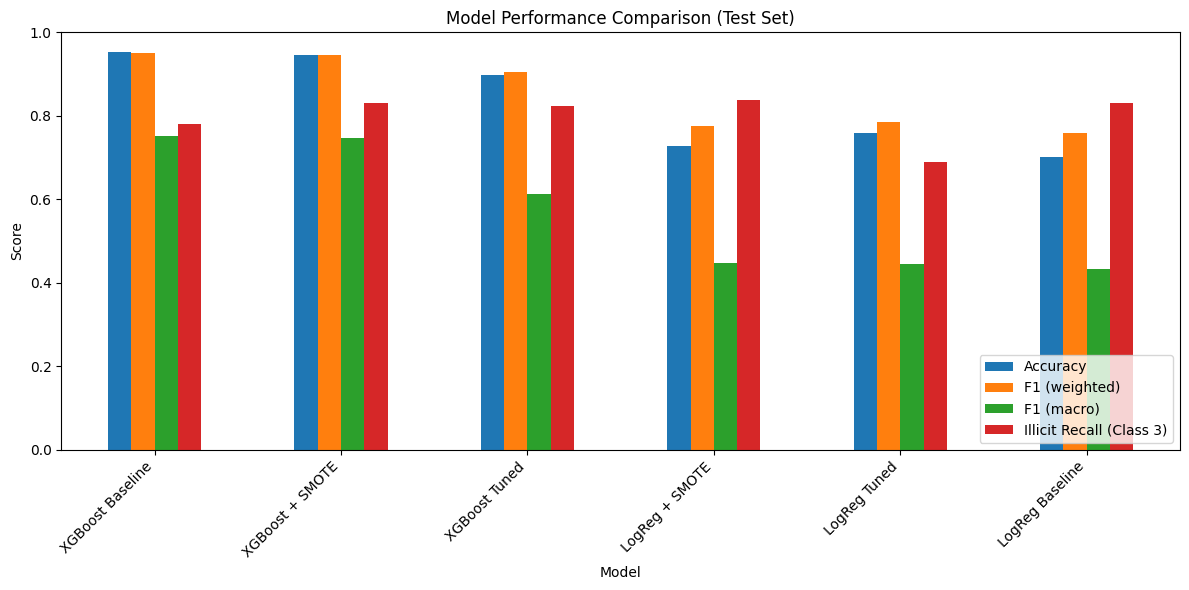

In [ ]:
def summarize_model(model_name: str, y_true, y_pred) -> dict:
    """Return key classification metrics for model comparison."""
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "Illicit Recall (Class 3)": recall_score(y_true, y_pred, labels=[3], average=None)[0]
    }

# Collect predictions here
predictions = {
    "LogReg Baseline": y_pred_lr_base,
    "LogReg + SMOTE": y_pred_lr_smote,
    "LogReg Tuned": y_pred_lr_tuned,
    "XGBoost Baseline": y_pred_xgb_base,
    "XGBoost + SMOTE": y_pred_xgb_smote,
    "XGBoost Tuned": y_pred_xgb_tuned
}

summary_rows = [summarize_model(name, y_test, y_pred) for name, y_pred in predictions.items()]
models_comparison = pd.DataFrame(summary_rows).sort_values(by="F1 (macro)", ascending=False)

display(models_comparison)

# Bar plot comparison
plot_columns = ["Accuracy", "F1 (weighted)", "F1 (macro)", "Illicit Recall (Class 3)"]

ax = models_comparison.set_index("Model")[plot_columns].plot(
    kind="bar",
    figsize=(12, 6)
)

plt.title("Model Performance Comparison (Test Set)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Cross-Model Comparison and Trade-Offs

Across all evaluated models, XGBoost consistently outperforms Logistic Regression in balancing minority-class detection with overall stability. Logistic Regression models (especially when combined with SMOTE or class weighting) tend to achieve higher recall for class 3 at the expense of precision, resulting in excessive false positives. While this behavior increases sensitivity, it is impractical in AML settings where alert volume must be controlled.

XGBoost models provide a more favorable trade-off: they maintain strong recall for illicit transactions while reducing unnecessary flagging of legitimate and low-risk activity. **The tuned XGBoost model achieves the best balance between macro-averaged performance and illicit-class recall, making it the most suitable candidate for deployment-oriented risk screening.**


## 8. Results and Discussion

### Interpretation of Results

The results show that machine learning models can meaningfully distinguish between different levels of transaction risk, particularly at the extremes of the risk spectrum. XGBoost models demonstrate a strong ability to separate legitimate transactions from illicit ones, while intermediate risk categories remain more challenging due to overlap in transaction characteristics.

Feature importance analysis indicates that illicit behavior is not driven by a single dominant attribute, but rather by combinations of transaction-level patterns. This supports the use of ensemble and nonlinear models, which are better suited to capturing complex interactions among features.

### Performance Across Risk Classes

Model performance varies substantially across classes. Extreme classes such as legitimate (Class 0) and illicit (Class 3) are identified more reliably than intermediate classes. High-risk unknown transactions (Class 2) are the most difficult to classify due to their indirect label construction and limited sample size.

This behavior reflects a realistic AML scenario in which suspicious activity exists along a continuum rather than as separable categories.

### Misclassification Patterns

Most misclassifications occur between adjacent risk levels (low-risk vs. high-risk unknown, and high-risk unknown vs. illicit). This suggests that errors are not random but follow a logical risk gradient. Confusion between legitimate and illicit transactions is relatively rare, which is desirable in an AML context.

### Limitations and Challenges

This analysis has several important limitations:

1. **Label Construction Bias**  
   Classes 1 and 2 are derived from graph proximity rather than confirmed ground truth. Some high-risk unknown transactions may ultimately be benign.

2. **Severe Class Imbalance**  
   Class 2 has extremely low support, making evaluation metrics unstable and sensitive to small changes.

3. **SMOTE Realism**  
   SMOTE introduces synthetic samples that may not perfectly reflect real blockchain transactions. While useful for training stability, this may distort true distributions.

4. **Graph Information Excluded from Features**  
   Graph structure is used only for label creation to avoid leakage. Real AML systems would likely incorporate graph-based features directly.

The challenges encountered are:

- Managing extreme imbalance and avoiding models that ignore rare classes.
- Preventing leakage when labels depend on graph relationships.
- Large dataset size leading to convergence warnings and heavy compute for tuning.

### Cost of Errors and Ethical Considerations

In AML applications, false negatives (missing illicit transactions) are generally more costly than false positives, as they allow criminal activity to continue undetected. However, excessive false positives can inconvenience users and overwhelm compliance teams. The selected model reflects a deliberate trade-off that prioritizes illicit recall while maintaining reasonable precision.

Automated flagging systems can impact users through delayed transactions or account restrictions. Any deployment should always include human review, transparency around decision criteria, auditing for unintended bias, and clear appeal procedures for users to mitigate unintended harm and bias.

## 9. Conclusions

### Real-World Applicability

This project demonstrates that multi-class risk classification can provide more nuanced and actionable insights than binary illicit detection alone. In a real AML monitoring system, the final XGBoost model could be used as a transaction screening tool that assigns a risk tier to incoming transactions. Transactions predicted as high-risk or illicit could be prioritized for manual review or subjected to additional verification.

Because AML systems may have different risk tolerances, decision thresholds could be adjusted to either maximize illicit recall (catch as many illicit cases as possible) or increase precision (reduce false alerts). Operational deployment would likely rely on predicted risk probabilities rather than hard class labels, allowing institutions to adjust thresholds based on regulatory requirements and risk tolerance.


### Future Work

Several extensions could improve performance and realism:

1. Integrating SMOTE or other resampling techniques winside each CV fold during cross-validation.
2. Incorporating graph-derived features (e.g., neighborhood risk ratios) directly into the model.
3. Exploring cost-sensitive or focal-loss-based learning to better handle extreme imbalance.
4. Evaluating precision-recall trade-offs across different operating thresholds for deployment.

## 10. References


1. Dataset: Elliptic Bitcoin Transaction. Available at: https://www.kaggle.com/datasets/ellipticco/elliptic-data-set

2. scikit-learn documentation: https://scikit-learn.org/

3. XGBoost Documentation: https://xgboost.readthedocs.io/en/stable/